In [26]:
import pandas as pd
import numpy as np
import shap
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import featuretools as ft
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv("../ex1/classification/clean_telecom.csv", index_col="Unnamed: 0")
# define target variable for further use
target = "churn"
# Reset index so that DFS works
df = df.reset_index(drop=True)
df

,seniorcitizen,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,churn,service_count,family,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check
0,0,1,0,1,1,1,29.85,0,1,1,0,0,1
1,0,34,0,1,2,0,56.95,0,2,0,0,0,0
2,0,2,0,1,1,1,53.85,1,2,0,0,0,0
3,0,45,0,1,2,0,42.30,0,3,0,1,0,0
4,0,2,0,2,1,1,70.70,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6675,0,24,1,1,2,1,84.80,0,5,1,0,0,0
6676,0,72,1,2,2,1,103.20,0,4,1,0,1,0
6677,0,11,0,1,1,1,29.60,0,1,1,0,0,1
6678,1,4,1,2,1,1,74.40,1,0,1,0,0,0


In previous exercises, some iteractions are already perfomed. For example columns children and partner are joined into one feature called family. Another one is service_count, which was originally bunch of additional services. 

In [28]:
df.corr()

,seniorcitizen,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,churn,service_count,family,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check
seniorcitizen,1.00,-0.03,0.14,0.27,-0.19,0.19,0.22,0.15,0.04,-0.03,-0.04,-0.08,0.22
tenure,-0.03,1.00,0.33,0.02,0.68,0.00,0.24,-0.38,0.49,0.37,0.25,0.23,-0.22
multiplelines,0.14,0.33,1.00,0.36,0.10,0.18,0.50,0.04,0.29,0.13,0.08,0.06,0.09
internetservice,0.27,0.02,0.36,1.00,-0.30,0.40,0.91,0.32,0.46,-0.03,-0.02,-0.05,0.39
contract,-0.19,0.68,0.10,-0.30,1.00,-0.19,-0.09,-0.41,0.28,0.31,0.20,0.22,-0.36
paperlessbilling,0.19,0.00,0.18,0.40,-0.19,1.00,0.37,0.21,0.19,-0.04,-0.02,-0.01,0.21
monthlycharges,0.22,0.24,0.50,0.91,-0.09,0.37,1.00,0.19,0.72,0.07,0.04,0.02,0.29
churn,0.15,-0.38,0.04,0.32,-0.41,0.21,0.19,1.00,-0.11,-0.18,-0.14,-0.17,0.34
service_count,0.04,0.49,0.29,0.46,0.28,0.19,0.72,-0.11,1.00,0.20,0.12,0.13,0.03
family,-0.03,0.37,0.13,-0.03,0.31,-0.04,0.07,-0.18,0.20,1.00,0.10,0.10,-0.11


In [29]:
class TrainModel():
    def __init__(self, df, target_col, model=XGBClassifier()):
        self.df = df
        self.target_column = target_col
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = model
        self.predictions = None
        self.metrics_df = pd.DataFrame({'Metric': ['Mean Squared Error', 
                                                   'Root Mean Squared Error', 
                                                   'Mean Absolute Error', 
                                                   'R-squared']})

    def split_data(self):
        """Splits the data into X/y and X/y train/test"""
        self.X = self.df.drop(columns=[self.target_column])
        self.y = self.df[self.target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def train(self):
        """Trains model and save predictions"""
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)
        self.predictions = [round(value) for value in y_pred]

    def print_metrics(self):
        """Prints metrics"""
        print(classification_report(self.y_test, self.predictions))

    def training_pipeline(self):
        self.split_data()
        self.train()
        self.print_metrics()

        

In [30]:
trainer_before = TrainModel(df, target)
trainer_before.training_pipeline()

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1014
           1       0.58      0.52      0.55       322

    accuracy                           0.79      1336
   macro avg       0.72      0.70      0.71      1336
weighted avg       0.79      0.79      0.79      1336



In [31]:
class FeatureImportance:
    def __init__(self, df, target_col, model=XGBClassifier(), n_features=8):
        self.df = df
        self.target_column = target_col
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = model
        self.n_features_to_select = n_features
    
    def split_data(self):
        """Splits the data into X/y and X/y train/test"""
        self.X = self.df.drop(columns=[self.target_column])
        self.y = self.df[self.target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def rfe(self):
        """"Performs RFE (Recursive Feature Elimination)"""
        rfe = RFE(estimator=self.model, n_features_to_select=self.n_features_to_select)
        rfe.fit(self.X, self.y)
        # get rankings and the results
        rankings = rfe.ranking_
        support = rfe.support_

        # build a new DataFrame just to show results of RFE
        results_df = pd.DataFrame({
            "Feature": self.X.columns,
            "Ranking": rankings,
            "Selected": support
        }).sort_values(by="Ranking")

        print(f"RFE: \n{results_df}")

    def mutual_info(self):
        """Performs Mutual Information test"""
        # fit the mutual information algorithm
        mi = mutual_info_regression(self.X, self.y)

        # convert results into DataFrame
        mi_results = pd.Series(mi, index=self.X.columns).sort_values(ascending=False)

        print(f"Mutual information: \n{mi_results}")

    def shap_info(self):
        """Performs SHAP analysis"""
        # Train model
        self.model.fit(self.X_train, self.y_train)

        # Initialize SHAP explainer
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.X_test)

        # Plot SHAP summary
        shap.summary_plot(shap_values, self.X_test)

    def f_score(self):
        """Performs Fisher score test"""
        # convert all continuous variables to integer,
        # and convert all negative numbers to 0
        X_cat = self.X.astype(int)
        X_cat = X_cat.clip(lower=0)

        # initialize chi2 and SelectKBest
        chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

        # fit our data to the SelectKBest
        best_features = chi_2_features.fit(X_cat, self.y.astype(int))

        # use decimal format in table print later
        pd.options.display.float_format = '{:.2f}'.format

        # wrap it up, and show the results
        # the higher the score, the more effect that column has on price
        df_features = pd.DataFrame(best_features.scores_)
        df_columns = pd.DataFrame(X_cat.columns)
        f_scores = pd.concat([df_columns,df_features],axis=1)
        f_scores.columns = ['Features','Score']
        f_scores = f_scores.sort_values(by='Score',ascending=False)
        print(f"F-score: \n{f_scores}")

    def feature_importance_pipeline(self):
        """Creates pipeline of all previous tests and prints the results"""
        self.split_data()
        self.rfe()
        print()
        self.mutual_info()
        print()
        self.shap_info()
        print()
        self.f_score()


<h1>Feature importance</h1>

RFE: 
                                    Feature  Ranking  Selected
1                                    tenure        1      True
2                             multiplelines        1      True
3                           internetservice        1      True
4                                  contract        1      True
5                          paperlessbilling        1      True
7                             service_count        1      True
10    paymentmethod_Credit card (automatic)        1      True
11           paymentmethod_Electronic check        1      True
6                            monthlycharges        2     False
9   paymentmethod_Bank transfer (automatic)        3     False
8                                    family        4     False
0                             seniorcitizen        5     False

Mutual information: 
contract                                  0.10
paymentmethod_Electronic check            0.07
tenure                                    0.07
monthlycharg

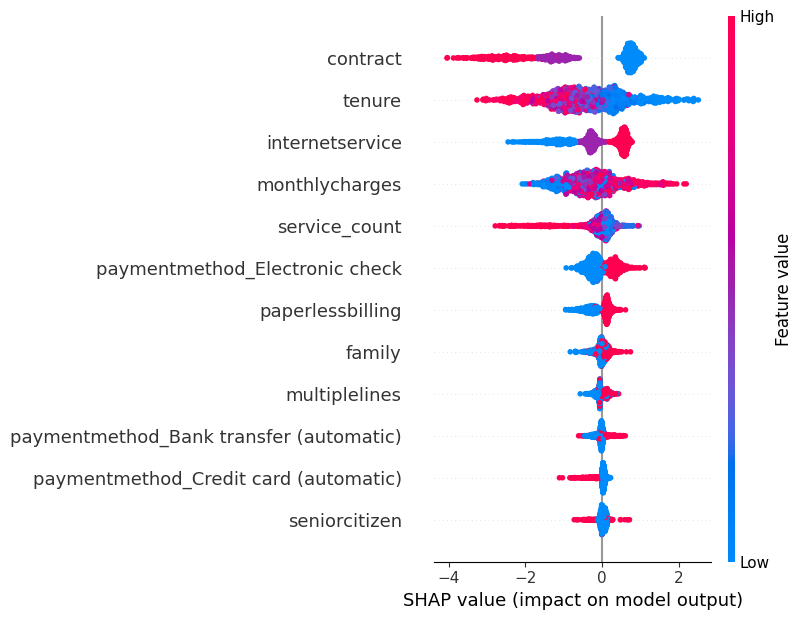


F-score: 
                                   Features    Score
1                                    tenure 18065.56
6                            monthlycharges  3311.28
11           paymentmethod_Electronic check   498.20
4                                  contract   460.39
3                           internetservice   345.49
10    paymentmethod_Credit card (automatic)   157.04
7                             service_count   142.41
0                             seniorcitizen   131.87
5                          paperlessbilling   116.15
9   paymentmethod_Bank transfer (automatic)    99.08
8                                    family    97.57
2                             multiplelines     5.20


In [32]:
feature_importance = FeatureImportance(df, target)
feature_importance.feature_importance_pipeline()

I suppose, I can join automatic credit card payment and bankr transfer to the same category automatic payment. 

Another way is to delete them, but it will be joined to "mailed check" category (I encoded and deleted one last category in exercise 1) and I believe that joining mailed check with automatic payments into "other" is not so wise.

Also I should get rid of seniorcitizen column, as it looks like it doesn't affect target variable according to all tools used.

In [33]:
# combine automatic payments using logical OR
df["paymentmethod_automatic"] = df["paymentmethod_Bank transfer (automatic)"] | df["paymentmethod_Credit card (automatic)"]
# drop old columns
df = df.drop(["paymentmethod_Credit card (automatic)", "paymentmethod_Bank transfer (automatic)"], axis=1)

In [34]:
# drop seniorcitizen column
df = df.drop("seniorcitizen", axis=1)

In [35]:
df

,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,churn,service_count,family,paymentmethod_Electronic check,paymentmethod_automatic
0,1,0,1,1,1,29.85,0,1,1,1,0
1,34,0,1,2,0,56.95,0,2,0,0,0
2,2,0,1,1,1,53.85,1,2,0,0,0
3,45,0,1,2,0,42.30,0,3,0,0,1
4,2,0,2,1,1,70.70,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6675,24,1,1,2,1,84.80,0,5,1,0,0
6676,72,1,2,2,1,103.20,0,4,1,0,1
6677,11,0,1,1,1,29.60,0,1,1,1,0
6678,4,1,2,1,1,74.40,1,0,1,0,0


Tenure is how long customer has been with a company and paid bills. I can multiply them and get total charges.

In [36]:
df["total_charges"] = df.monthlycharges * df.tenure


<h1>Cluster Profiling</h1>
First of all, elbow plot to find out best K paramter.

Text(0, 0.5, 'Inertia score (SSE)')

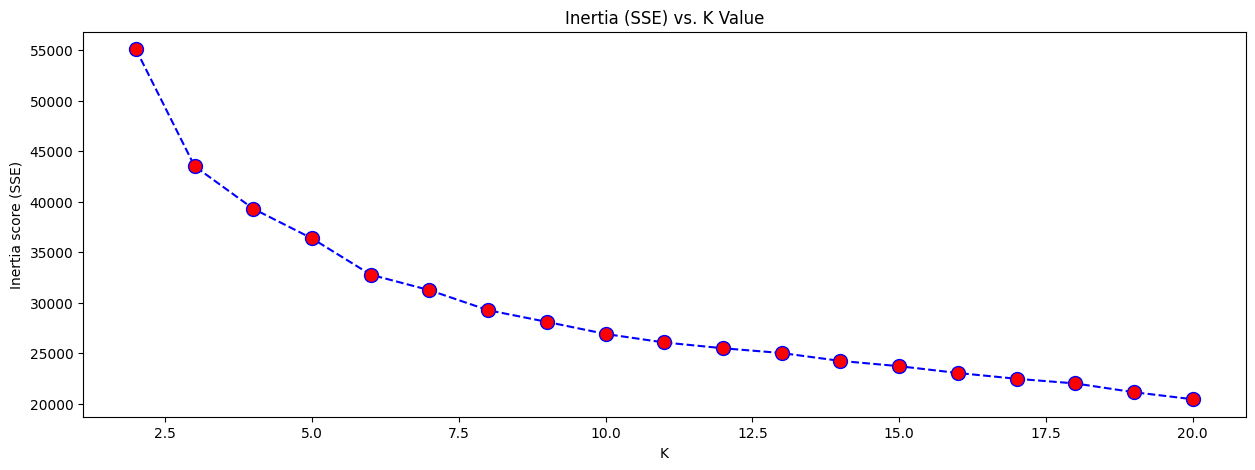

In [37]:
# X/y -split
X = df.drop(target, axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k1 = []
inertia_s1 = []

for i in range(2,21):
    k1.append(i)
    kmeans1 = KMeans(n_clusters=i,random_state=125,max_iter=100).fit(X_scaled)
    inertia_s1.append(kmeans1.inertia_)

# plot
plt.figure(figsize=(15,5))
plt.plot(k1,inertia_s1,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Inertia (SSE) vs. K Value')
plt.xlabel('K')
plt.ylabel('Inertia score (SSE)')

5-6 clusters seems to be the best solution

In [38]:

# create Kmeans-instance and train it with data
kmeans = KMeans(n_clusters=5, random_state=333)

# place the cluster values back to DataFrame
df['cluster'] = kmeans.fit_predict(X_scaled)


In [39]:
cluster_counts = df.groupby([target, 'cluster']).size().unstack(fill_value=0)
print(cluster_counts)

cluster     0    1     2    3    4
churn                             
0        1614  569  1158  757  907
1         144  257    50  907  317


In [40]:
df.columns

Index(['tenure', 'multiplelines', 'internetservice', 'contract',
       'paperlessbilling', 'monthlycharges', 'churn', 'service_count',
       'family', 'paymentmethod_Electronic check', 'paymentmethod_automatic',
       'total_charges', 'cluster'],
      dtype='object')

We could use cluster average contract, tenure, monthly charges and additional service amount

In [41]:
features = ["tenure", "contract", "monthlycharges", "service_count"]
for feature in features:   
    # calculate the average of feature for each cluster
    cluster_average = df.groupby('cluster')[feature].mean()

    # place the averages based on clusters back into DataFrame
    df[f'cluster_average_{feature}'] = df['cluster'].map(cluster_average)
df

,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,churn,service_count,family,paymentmethod_Electronic check,paymentmethod_automatic,total_charges,cluster,cluster_average_tenure,cluster_average_contract,cluster_average_monthlycharges,cluster_average_service_count
0,1,0,1,1,1,29.85,0,1,1,1,0,29.85,3,10.47,1.04,68.86,1.37
1,34,0,1,2,0,56.95,0,2,0,0,0,1936.30,0,28.67,1.99,24.91,0.24
2,2,0,1,1,1,53.85,1,2,0,0,0,107.70,3,10.47,1.04,68.86,1.37
3,45,0,1,2,0,42.30,0,3,0,0,1,1903.50,4,24.64,1.27,70.96,2.22
4,2,0,2,1,1,70.70,1,0,0,1,0,141.40,3,10.47,1.04,68.86,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6675,24,1,1,2,1,84.80,0,5,1,0,0,2035.20,1,47.01,1.59,93.52,3.35
6676,72,1,2,2,1,103.20,0,4,1,0,1,7430.40,2,62.08,2.55,87.95,4.23
6677,11,0,1,1,1,29.60,0,1,1,1,0,325.60,3,10.47,1.04,68.86,1.37
6678,4,1,2,1,1,74.40,1,0,1,0,0,297.60,3,10.47,1.04,68.86,1.37


RFE: 
                           Feature  Ranking  Selected
0                           tenure        1      True
2                  internetservice        1      True
3                         contract        1      True
4                 paperlessbilling        1      True
8   paymentmethod_Electronic check        1      True
12          cluster_average_tenure        1      True
13        cluster_average_contract        1      True
14  cluster_average_monthlycharges        1      True
1                    multiplelines        2     False
9          paymentmethod_automatic        3     False
6                    service_count        4     False
10                   total_charges        5     False
5                   monthlycharges        6     False
11                         cluster        7     False
7                           family        8     False
15   cluster_average_service_count        9     False

Mutual information: 
contract                         0.11
cluster_average_

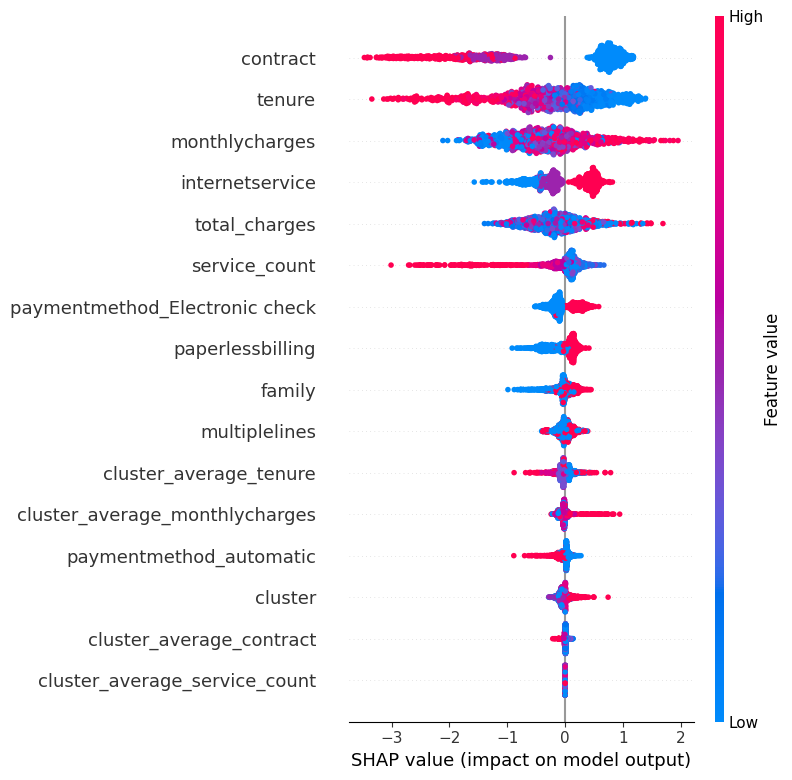


F-score: 
                          Features     Score
10                   total_charges 790425.81
0                           tenure  18065.56
12          cluster_average_tenure   6940.75
5                   monthlycharges   3311.28
14  cluster_average_monthlycharges   1141.06
8   paymentmethod_Electronic check    498.20
3                         contract    460.39
11                         cluster    450.07
2                  internetservice    345.49
9          paymentmethod_automatic    251.95
6                    service_count    142.41
4                 paperlessbilling    116.15
7                           family     97.57
15   cluster_average_service_count     57.76
13        cluster_average_contract     43.16
1                    multiplelines      5.20


In [42]:
feature_importance = FeatureImportance(df, target)
feature_importance.feature_importance_pipeline()

In [43]:
correlation = [df[target].corr(df['cluster_average_monthlycharges']), df[target].corr(df['cluster_average_tenure']), df[target].corr(df['cluster'])]
# Correlation of cluster average monthly charges, tenure and cluster itself with target variable
correlation

[np.float64(0.13049471183522024),
 np.float64(-0.31849759272482553),
 np.float64(0.24777134571869072)]

Looks like cluster average contract and service count is not as usefull, I could drop them as well as original tenure and monthly charges (because already have total charges) and leave cluster average monthly costs and tenure.

In [44]:
df = df.drop(["monthlycharges", "tenure", "cluster_average_service_count", "cluster_average_contract"], axis=1)

In [45]:
trainer_after = TrainModel(df, target)
trainer_after.training_pipeline()

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1014
           1       0.57      0.51      0.54       322

    accuracy                           0.79      1336
   macro avg       0.71      0.69      0.70      1336
weighted avg       0.78      0.79      0.78      1336



In [46]:
trainer_before.print_metrics()

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1014
           1       0.58      0.52      0.55       322

    accuracy                           0.79      1336
   macro avg       0.72      0.70      0.71      1336
weighted avg       0.79      0.79      0.79      1336



Turns out, not a single idea worked. Model got only slightly worse. Atleast for the XGBoost. I believe that for some models there might be actual difference between before and after. But for xgboost this dataset was "good enough" and it doesn't really care about clusters and support variables.

Might be clustering was not good enough, in of the clusters there were almost 50/50 distribution and clustering algorythm is struggling with classyfying as well.

Another problem of the dataset might be amount of rows.

Something positive: I tried python custom classes here and it feels good. So good that I am planning to make own library with all ML things that we used in previous courses, so there there is no need to search for them in different places.